In [1]:
from utility import *
from summary_models import *
from cl_models import RNVP, NSF_CL
from ar_models import NSF_AR, MAF
from classifier import ResNet
from plot import pairplot
from dataloader import *
from sbi import utils
#my_module_path = os.path.join("../", '21cm-wrapper')
#sys.path.append(my_module_path)
#from Leaf import * 
#from sbi import analysis

%matplotlib inline

device = 'cuda'

#torch.set_num_interop_threads(4) # Inter-op parallelism
#torch.set_num_threads(6) # Intra-op parallelism


NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
# hyperparams
data_path = "/home/allomere/Documents/projects/master/data/datax5/"
batch_size = 32
epochs = 40
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 5e-4,
}


loss = torch.nn.MSELoss
loss_params = {}

norm_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)


# transform trainingsdata
# perhaps add check if file is there: continue + override option in the future
#convert_to_torch(path = data_path, prefix="run", redshift_cutoff=600, debug=False, statistics=True)

# load data
train_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0.5)
test_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = False,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True,
                             num_workers = 2, pin_memory = True, prefetch_factor=2)

# init model
model_sn = SumnetHandler(Summary_net_1dps, device = device)
#model_sn.load("./summary_net.pt")
model_rec = RecNetHandler(Model = global_temp_smol_inv_super_smol, summary_net = model_sn.Model, device=device)


'''# train
model_sn.train(
    epochs=epochs,
    optimizer=optimizer(
        model_sn.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model_sn.test(Validation_data = test_dataloader, Model = model_sn.Model, 
                lossf=loss(**loss_params))'''
                


#model_de = flow_net(in_dim=6, cond_dim=6, n_blocks=6, n_nodes=128)

summary(model_sn.Model, (10,8))

'''model_rec.train(epochs = 10, training_data = train_dataloader,
                    test_data = test_dataloader, optimizer = optimizer,
                    optimizer_kwargs = optimizer_params)

model_rec.test_specific(Validation_data=test_dataloader)'''

torch.Size([2, 10, 8])
torch.Size([2, 48, 1])
torch.Size([2, 48])
torch.Size([2, 6])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 8]             496
              ReLU-2                [-1, 16, 8]               0
         MaxPool1d-3                [-1, 16, 4]               0
            Conv1d-4                [-1, 32, 4]           1,568
              ReLU-5                [-1, 32, 4]               0
         MaxPool1d-6                [-1, 32, 2]               0
            Conv1d-7                [-1, 48, 2]           4,656
              ReLU-8                [-1, 48, 2]               0
         MaxPool1d-9                [-1, 48, 1]               0
          Flatten-10                   [-1, 48]               0
           Linear-11                   [-1, 32]           1,568
             ReLU-12                   [-1, 32]               0
           Linear-

'model_rec.train(epochs = 10, training_data = train_dataloader,\n                    test_data = test_dataloader, optimizer = optimizer,\n                    optimizer_kwargs = optimizer_params)\n\nmodel_rec.test_specific(Validation_data=test_dataloader)'

In [3]:
batch_size = 16
epochs = 3
freezed_epochs = 0
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 3e-4,
}

'''model_de = RNVP(in_dim=6, n_blocks=6, n_nodes=128, reversed=False,
               hidden_layer=1, batch_norm=True, device=device)

model_de = testmodel(inference._neural_net)

sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, device=device)

'''

rec_model = global_temp_smol_inv_super_smol(in_dim = 6)
density_model = MAF(in_dim=6, n_blocks=6, n_nodes=64, reversed=True,
               hidden_layer=2, batch_norm=True, device=device)
summary_net = SumnetHandler(Summary_net_1dps, device = device)
#summary_net.load("./summary_net.pt")

sbi = SBIHandler(density_estimator = density_model, summary_net = summary_net.Model,
 device = device)
sbi.train(training_data = train_dataloader, test_data = test_dataloader, epochs = epochs, 
freezed_epochs = freezed_epochs, pretrain_epochs = 0, optimizer = optimizer,
              optimizer_kwargs = optimizer_params, loss_function = torch.nn.MSELoss, 
              #loss_params = {'reduction': 'none', 'kernel_size': 1}, 
              device = device, plot = True,
              grad_clip = 0)


TypeError: MSELoss.__init__() got an unexpected keyword argument 'kernel_size'

In [6]:
for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    lab, img = lab.unsqueeze(0), img.unsqueeze(0)
    print("lab=",lab)
    summary = sbi.summary_net(img).detach()
    print('summary=',summary.detach())
    sbi.density_estimator.reversed = False
    samples, logprob = sbi.density_estimator.inverse(summary.repeat(10,1), torch.rand(10,6, device=device))
    print('samples=', samples.detach())
    print('logprob=',logprob.detach())
    

lab= tensor([[0.0573, 0.5426, 0.2409, 0.3191, 0.1151, 0.1421]], device='cuda:0')
summary= tensor([[0.4691, 0.5377, 0.4535, 0.5267, 0.4921, 0.4915]], device='cuda:0')
samples= tensor([[0.4688, 0.5371, 0.4535, 0.5264, 0.4924, 0.4934],
        [0.4688, 0.5371, 0.4535, 0.5264, 0.4924, 0.4935],
        [0.4688, 0.5371, 0.4536, 0.5264, 0.4926, 0.4938],
        [0.4688, 0.5371, 0.4535, 0.5264, 0.4925, 0.4937],
        [0.4688, 0.5371, 0.4535, 0.5263, 0.4924, 0.4936],
        [0.4688, 0.5370, 0.4536, 0.5264, 0.4925, 0.4937],
        [0.4688, 0.5370, 0.4536, 0.5264, 0.4926, 0.4937],
        [0.4688, 0.5370, 0.4536, 0.5264, 0.4926, 0.4938],
        [0.4688, 0.5371, 0.4535, 0.5264, 0.4924, 0.4934],
        [0.4688, 0.5370, 0.4536, 0.5264, 0.4926, 0.4937]], device='cuda:0')
logprob= tensor([[-9.5268, -9.2932, -9.5281, -9.2916, -8.5240, -8.2910],
        [-9.5192, -9.3051, -9.5052, -9.2792, -8.5136, -8.2961],
        [-9.5114, -9.2778, -9.5110, -9.2974, -8.5585, -8.3196],
        [-9.5178, -9.2808,

In [5]:

save = True
'''prior = (lambda x: x)
sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, device=device)
sbi.load_model()'''
sbi.summary_net.to('cuda')
sbi.density_estimator.to('cuda')

for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)
    sbi.density_estimator.reversed = True
    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    nsamples = 10000
    samples = sbi.density_estimator.sample(num_samples=nsamples, x=summary, enable_transform=False,
                                           sample_with='rejection', mcmc_method="slice_np_vectorized",
                                           mcmc_parameters={'num_chains': 10})
    # plot posterior samples
    figure, axis = pairplot(samples = samples.detach().cpu().numpy(), points=lab.detach().cpu().numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"nle_{i}.png", dpi=300)
    figure.show()



torch.Size([10000, 6]) torch.Size([10000, 6])
torch.Size([1000, 6]) torch.Size([1000, 6])


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1000, 6]], which is output 0 of torch::autograd::CopySlices, is at version 6; expected version 5 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [5]:
# sbi
with torch.no_grad():
    for i, (lab, img,_) in enumerate(test_dataloader):
        img, lab = img.to(device), lab.to(device)
        
        if not i:
            summary_vec = torch.empty(0,lab.shape[1], device=device)
            labels = torch.empty(0,lab.shape[1], device=device)

        pred = sbi.summary_net(img)
        summary_vec = torch.cat((summary_vec, pred), dim=0)
        labels = torch.cat((labels, lab), dim=0)

num_samples = 10000
rank_inn = torch.empty(summary_vec.shape)
dap_samples = torch.empty((summary_vec.shape[0], summary_vec.shape[1]))
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = sbi.density_estimator.sample(x = summary_vec[i].unsqueeze(0), num_samples=num_samples,
                                                 enable_transform=False,
                                           sample_with='mcmc', mcmc_method="slice_np_vectorized")
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_inn[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()
        
'''rank_maf = torch.empty(summary_vec.shape)
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = posterior.posterior_estimator.sample((10000,), summary_vec[i].unsqueeze(0))[:,0,:]
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_maf[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()'''


on 0: torch.Size([1, 10000, 6])                                                 


on 0: /home/allomere/Documents/projects/master/master-venv/lib/python3.12/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
        thin = _process_thin_default(thin)


|⚠︎                                       | (!) 0/1120 [0%] in 0.0s (0.00/s)     


RuntimeError: The size of tensor a (6) must match the size of tensor b (10000) at non-singleton dimension 0

In [ ]:

with torch.no_grad():
    for i, (lab, img,_) in enumerate(test_dataloader):
        img, lab = img.to(device), lab.to(device)
        
        if not i:
            summary_vec = torch.empty(0,lab.shape[1], device=device)
            labels = torch.empty(0,lab.shape[1], device=device)

        pred = sbi.summary_net(img)
        summary_vec = torch.cat((summary_vec, pred), dim=0)
        labels = torch.cat((labels, lab), dim=0)

num_samples = 10000
rank_inn = torch.empty(summary_vec.shape)
dap_samples = torch.empty((summary_vec.shape[0], summary_vec.shape[1]))
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = sbi.density_estimator.sample(x = summary_vec[i].unsqueeze(0), num_samples=num_samples,
                                                 enable_transform=False,
                                           sample_with='mcmc', mcmc_method="slice_np_vectorized")
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_inn[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()
        
'''rank_maf = torch.empty(summary_vec.shape)
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = posterior.posterior_estimator.sample((10000,), summary_vec[i].unsqueeze(0))[:,0,:]
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_maf[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()'''


In [4]:
plt.hist(samples[:,0].detach().cpu(), range=(-5,5), bins=20)

NameError: name 'samples' is not defined

In [16]:
for i in range(3):
    lab, img, _ = test_dataloader.dataset[i+2]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    summaryn = summary.repeat(5,1)
    labn = torch.cat([lab.unsqueeze(0), torch.rand(4,6, device=device)], dim=0)
    log_prob = sbi.density_estimator.log_prob(summaryn, labn)
    print(- (logp.sum(-1) + sbi.density_estimator.base_dist.log_prob(samples).sum(-1)))
    print(log_prob.shape)
    print(lab)
    print(density_net.log_prob(summaryn.unsqueeze(0),labn).shape)
    break
utils.BoxUniform(low=torch.zeros(6), high=torch.ones(6), device=device).log_prob(samples)

start: torch.Size([5, 6]) torch.Size([5, 6])
end: torch.Size([5, 6]) torch.Size([5, 6])
tensor([-12.8277,  53.2448,  93.8413, 212.1874, 153.2469], device='cuda:0',
       grad_fn=<NegBackward0>)
torch.Size([5])
tensor([0.7003, 0.3817, 0.0350, 0.7115, 0.0431, 0.1985], device='cuda:0')
torch.Size([1, 5])


tensor([-inf, -inf, -inf, -inf, -inf], device='cuda:0')

In [8]:
samples[0].shape

torch.Size([10000, 6])

In [33]:
print(-density_net.log_prob(labn.unsqueeze(0), summaryn))
s, p = sbi.density_estimator.forward(summaryn, labn)
p = p.sum(-1) + sbi.density_estimator.base_dist.log_prob(s).sum(-1)
print(-p)

torch.Size([5, 6]) torch.Size([5, 6])
tensor([[-3.1623,  4.8708, 30.3841, 17.8690, 11.3792]], device='cuda:0',
       grad_fn=<NegBackward0>)
tensor([ -8.5420,   3.5507, 211.3264,  15.8320,  75.5712], device='cuda:0',
       grad_fn=<NegBackward0>)


In [48]:
summaryn = summary.squeeze(0)
labn = labn
print(summaryn.shape, labn.shape)
density_net.log_prob(labn, summaryn)

torch.Size([6]) torch.Size([5, 6])


ValueError: Expected features = 6, got 1.

In [6]:
device = 'cuda'
sbi.density_estimator.net.to(device)
sbi.device = device
prior = utils.BoxUniform(low=torch.zeros(6), high=torch.ones(6), device=device)
potential_fn = LikelihoodBasedPotential(sbi.density_estimator, prior, x_o=None, device=device)

In [7]:
potential_fn.set_x(torch.rand(1,6, device=device))
print(potential_fn(torch.rand(10,6, device=device)))

posterior = MCMCPosterior(
    potential_fn=potential_fn, proposal=prior
)

tensor([-4.7421, -5.3013, -5.7116, -5.2028, -4.9545, -5.5176, -5.9892, -5.0671,
        -6.1681, -5.4792], device='cuda:0', grad_fn=<AddBackward0>)


/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:114: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [10]:
utils.BoxUniform(low=torch.zeros(6), high=torch.ones(6), device=device).log_prob(torch.rand(10,6, device='cuda')).shape

torch.Size([10])

In [4]:
for lab, x, _ in test_dataloader:
    break

batch_size=1
batch_size_prior = 32
x = sbi.summary_net.to('cpu')(x)[0].unsqueeze(0)
sbi.density_estimator.to('cpu')
sbi.device = 'cpu'
theta_prior = torch.rand(32, 6)
repeated_x =  repeat_rows(x, 11)
lab = lab[0].unsqueeze(0)
probs = torch.cat(
        [(1 - torch.eye(batch_size)), torch.ones(batch_size, batch_size_prior)], dim=-1
        ) / (batch_size + batch_size_prior - 1)
choices = torch.multinomial(probs, num_samples=10, replacement=False)

contrasting_theta = torch.cat([lab, theta_prior], dim=0)[choices]
atomic_theta = torch.cat((lab[:, None, :], contrasting_theta), dim=1).reshape(
    batch_size * (11), -1
)
res = sbi.density_estimator.forward(atomic_theta, repeated_x).reshape(
            batch_size, 10 + 1
        )

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [13]:
from torch import distributions as D
D.Uniform(0,1).sample((10,))

tensor([0.4181, 0.9885, 0.3814, 0.2518, 0.0467, 0.6059, 0.6123, 0.7393, 0.7152,
        0.3473])

In [3]:
torch.distributions.Uniform(0,1).sample((10,))

tensor([0.5687, 0.5405, 0.2084, 0.9713, 0.1074, 0.0154, 0.8659, 0.3474, 0.4490,
        0.4355])

In [5]:
sbi.density_estimator.base_dist.sample((10000,))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
plt.hist2d?

In [ ]:
'''prior = (lambda x: x)
sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, device=device)
sbi.load_model()'''

lab, img, _ = test_dataloader.dataset[3]

lab, img = lab.to(device), img.to(device)
img = img.unsqueeze(0)

summary = sbi.summary_net(img)

samples, _ = sbi.density_estimator.sample(10000, summary)
print(samples.shape)
# plot posterior samples
figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
       limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
       labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
       #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
       upper = 'hist', lower = 'contour', diag = 'kde')
figure.savefig("inn_40.png", dpi=300)
figure.show()

In [ ]:
plt.hist(posterior.posterior_estimator.sample((1000,), summary_vec[0].unsqueeze(0))[:,0,0].detach().cpu().numpy(), bins=50)
plt.show()

In [ ]:
### SNPE ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE
from sbi import utils, analysis
from sbi.utils import RestrictedPrior, get_density_thresholder

# load the summary model
model = SumnetHandler(Model = Summary_net_lc_super_smol, device=device)
model.load("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=128, num_transforms=6, z_score_theta='none',
    z_score_x='none', batch_norm=True
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=99,
                                    stop_after_epochs=99,
                                    max_num_epochs=20,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)


for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    nsamples = 1000
    samples = posterior.sample(nsamples, summary)
    # plot posterior samples
    figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"maf_theirs_{i}.png", dpi=300)
    figure.show()


In [ ]:
for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    nsamples = 1000
    samples = posterior.sample((nsamples,), summary)
    # plot posterior samples
    figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"maf_theirs_{i}.png", dpi=300)
    figure.show()

In [ ]:
### SNPE - backup ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6, z_score_theta='none',
    z_score_x='none', 
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=5,
                                    stop_after_epochs=20,
                                    max_num_epochs=20,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    #fig.savefig(f"./NPE_{i}.png", dpi=300)

In [ ]:
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )

In [ ]:
for i in range(10):
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)

    x = x.to(device)

    x = model.Model(x).detach()
    sample, prob = density_net.sample_and_log_prob(sample_shape=torch.tensor([1]), condition=x.to('cuda'))
    print("summary-vec = ", x)
    print("true-vec = ", y)
    print("sample-vec = ", sample.detach())
    print("prob = ", prob.item())
    print()
    

In [ ]:
?

In [ ]:
torch.unsqueeze(train_dataloader.dataset.__getitem__(0)[1],0).shape

In [ ]:
with open("delete.me", "wb") as handle:
    pickle.dump(density_net, handle)

In [ ]:
train_loss_summary_net, train_loss_density_net, test_loss_summary_net, test_loss_density_net = statistics
plt.plot(train_loss_summary_net, label=r'$\log \mathcal{L}_{\Phi_{train}}$')
plt.plot(np.asarray(train_loss_density_net)/32, label=r'$\log \mathcal{L}_{\varphi_{train}}$')   
plt.plot(test_loss_summary_net, label=r'$\log \mathcal{L}_{\Phi_{test}}$')
plt.plot(np.asarray(test_loss_density_net)/32, label=r'$\log \mathcal{L}_{\varphi_{test}}$')
plt.vlines(9, 0.5, 0, color='b', label='joint learning', colors='black')
plt.legend()
#plt.savefig("NPE_nsf_joint_loss.png", dpi=400)
plt.show()


In [12]:
### NRE ###



from sbi.utils.get_nn_models import (
    likelihood_nn
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNLE
from sbi import utils, analysis

# load the summary model
model = SumnetHandler(Model = Summary_net_lc_super_smol, device=device)
model.load("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
ratio_estimator = (lambda x,y: NSF_AR(in_dim=6, n_blocks=2, n_nodes=64, reversed=True,
               hidden_layer=1, batch_norm=True, device=device))

ratio_estimator = likelihood_nn(
    model = 'nsf', z_score_x='none',  z_score_theta='none', 
    hidden_features=64, num_blocks=3, use_batch_norm=True
)



# train the maf
inference = SNLE(prior=prior, device=device, density_estimator=ratio_estimator)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]

density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=50,
                                    stop_after_epochs=20,
                                    max_num_epochs=0,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((1000,), x=x, num_chains=5, mcmc_method='slice_np_vectorized').to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    fig.savefig(f"./NRE_{i}.png", dpi=300)

/tmp/ipykernel_29347/742182843.py:21: DeprecationWarning: This method is deprecated and will be removed in a future release. Please use `from sbi.neural_nets import likelihood_nn` in the future.
  ratio_estimator = likelihood_nn(
/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/base.py:324: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/base.py:324: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


on 0: test_loss_density_net[-1]=-10.123898996625627 test_loss_summary_net[-1]=0.016763895563781262 np.mean(test_blub)=0.0
|████████████████████████████████████████| 1 in 28.5s (0.04/s)                  
torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])


/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:114: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)
/tmp/ipykernel_29347/742182843.py:62: UserWarning: You passed `mcmc_method` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Use `method` instead of `mcmc_method`.
  posterior_samples = posterior.sample((1000,), x=x, num_chains=5, mcmc_method='slice_np_vectorized').to('cpu')


Running vectorized MCMC with 5 chains:   0%|          | 0/2250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
from sbi.inference.potentials.likelihood_based_potential import likelihood_estimator_based_potential

In [4]:
pot = LikelihoodBasedPotential(density_net, prior=prior, x_o=None, device='cuda')

In [5]:
pot.set_x(torch.rand(1,6, device='cuda'))
pot(torch.rand(10,6,device='cuda'))

torch.Size([1, 6])
torch.Size([1, 10, 6])
torch.Size([10, 6])
tensor([[ -49.8460, -102.8276,  -67.9825,  -22.5496,  -38.1928,  -25.0516,
         -113.9073,  -63.3235, -113.0540,  -46.1180]], device='cuda:0',
       grad_fn=<ViewBackward0>)
torch.Size([1, 10])


tensor([ -49.8460, -102.8276,  -67.9825,  -22.5496,  -38.1928,  -25.0516,
        -113.9073,  -63.3235, -113.0540,  -46.1180], device='cuda:0',
       grad_fn=<AddBackward0>)

torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])
torch.Size([1, 6])
torch.Size([1, 10000, 6])
torch.Size([10000, 6])
tensor([[-73.2180, -14.2202, -35.9242,  ..., -84.5549, -48.8229,  -8.1282]],
       device='cuda:0', grad_fn=<ViewBackward0>)
torch.Size([1, 10000])
torch.Size([1, 6])
torch.Size([1, 10000, 6])
torch.Size([10000, 6])
tensor([[ -41.2552,  -69.4269,   -9.0907,  ...,    7.0631,  -71.1170,
         -113.4336]], device='cuda:0', grad_fn=<ViewBackward0>)
torch.Size([1, 10000])
torch.Size([1, 6])
torch.Size([1, 10000, 6])
torch.Size([10000, 6])
tensor([[ -88.8621,  -35.3388,   -6.7782,  ..., -102.2345,  -30.6719,
          -97.9533]], device='cuda:0', grad_fn=<ViewBackward0>)
torch.Size([1, 10000])
torch.Size([1, 6])
torch.Size([1, 10000, 6])
torch.Size([10000, 6])
tensor([[-145.0902,  -32.7507,  -56.8727,  ..., -106.6974, -142.2654,
           -3.0945]], device='cuda:0', grad_fn=<ViewBackward0>)
torch.Size([1, 10000])
torch.Size([1, 6])
torch.Size([1, 10000, 6])
torch.Size([

/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:114: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)
/tmp/ipykernel_16035/368770371.py:30: UserWarning: You passed `mcmc_method` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Use `method` instead of `mcmc_method`.
  posterior_samples = posterior.sample((1000,), x=x, num_chains=20, mcmc_method='slice_np_vectorized').to('cpu')


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

torch.Size([1, 6])
torch.Size([1, 20, 6])
torch.Size([20, 6])
tensor([[7.6485, 7.7986, 8.0953, 8.4289, 6.5256, 8.5424, 7.5267, 6.8603, 8.5560,
         7.7965, 8.4527, 7.1388, 8.8408, 7.5350, 9.1166, 6.6191, 8.1852, 8.4686,
         6.5155, 8.1956]], device='cuda:0')
torch.Size([1, 20])
torch.Size([1, 6])
torch.Size([1, 20, 6])
torch.Size([20, 6])
tensor([[7.6476, 7.7983, 8.0996, 8.4293, 6.5484, 8.5422, 7.5267, 6.8579, 8.5289,
         7.7859, 8.4488, 7.1341, 8.8395, 7.5346, 9.1031, 6.6160, 8.1851, 8.4686,
         6.5154, 8.1902]], device='cuda:0')
torch.Size([1, 20])
torch.Size([1, 6])
torch.Size([1, 20, 6])
torch.Size([20, 6])
tensor([[7.6463, 7.7977, 8.1118, 8.4327, 6.6233, 8.5414, 7.5268, 6.8497, 8.4878,
         7.7736, 8.4437, 7.0973, 8.8383, 7.5337, 9.0816, 6.6126, 8.1849, 8.4686,
         6.5145, 8.1815]], device='cuda:0')
torch.Size([1, 20])
torch.Size([1, 6])
torch.Size([1, 20, 6])
torch.Size([20, 6])
tensor([[7.6450, 7.7970, 8.1232, 8.4359, 6.6976, 8.5405, 7.5269, 6.8417, 8

NameError: name 'save' is not defined

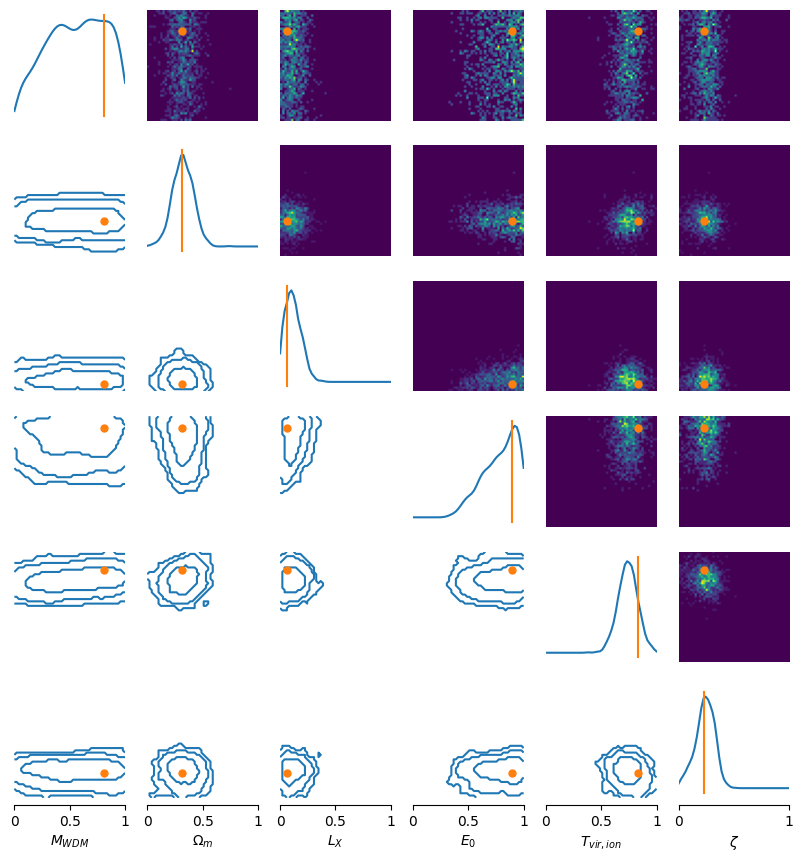

In [10]:
from sbi.inference import SNRE_C as SNRE
ratio_estimator = (lambda x,y: ResNet(in_dim=6, n_blocks=2, n_nodes=64,
               hidden_layer=2, batch_norm=True, device=device))

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

'''ratio_estimator = classifier_nn(
    model = 'resnet', z_score_x='none',  z_score_theta='none', 
    hidden_features=64, num_blocks=2, use_batch_norm=True
)'''

# train the maf
inference = SNLE(prior=prior, device=device, density_estimator=ratio_estimator)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((1000,), x=x, num_chains=20, mcmc_method='slice_np_vectorized').to('cpu')

    # plot posterior samples
    figure, axis = pairplot(samples = posterior_samples.cpu().numpy(), points=y.cpu().numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"nre_{i}_old.png", dpi=300)
    figure.show()
    
    fig.savefig(f"./NRE_{i}.png", dpi=300)

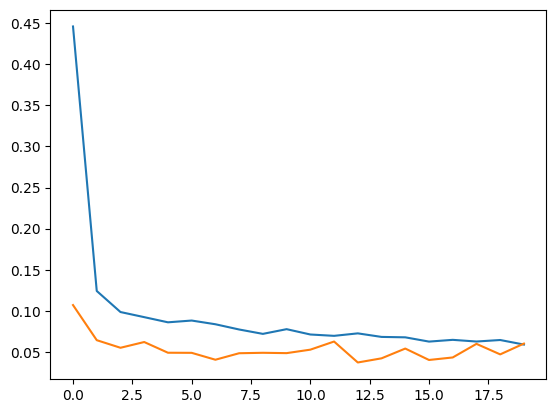

In [7]:
plt.plot(np.asarray(statistics)[1])
plt.plot(np.asarray(statistics)[3])

In [ ]:
from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot

In [ ]:
from sbi.utils.torchutils import repeat_rows
from torch import eye, ones
num_atoms=10

y,x,_ = test_dataloader.dataset.__getitem__(0)
y,x = y.unsqueeze(0), x.unsqueeze(0)
print(y.shape, x.shape)
x = model.Model(x)

y1, x1,_ = test_dataloader.dataset.__getitem__(1)
y1,x1 = y1.unsqueeze(0), x1.unsqueeze(0)
x1 = model.Model(x1)

y, x = torch.cat((y,y1)), torch.cat((x,x1))

batch_size = y.shape[0]
print(f'{batch_size=}')

repeated_x = repeat_rows(x, num_atoms)
print(f'{repeated_x=}')

# Choose `1` or `num_atoms - 1` thetas from the rest of the batch for each x.
probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)
print(f'{probs=}')

choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)

In [ ]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

In [ ]:
# take closer look at test
ModelHandler.test_specific(test_dataloader, model.Model, loss(**loss_params), 1, denormalize=test_data.denormalize)

# save the model
#model.save_model(name = "summary_net.pt")

In [ ]:
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# define model hyperparemeter
user_params = {
"HII_DIM": 40,
"BOX_LEN": 160,
"N_THREADS": 2,
"USE_INTERPOLATION_TABLES": True,
"PERTURB_ON_HIGH_RES": True
}

flag_options = {
"INHOMO_RECO": True,
"USE_TS_FLUCT": True
}

#simparams = p21c.outputs.LightCone.read("./data/run_36690")
# load the simulator class
Leaf_simulator = Leaf(debug=True, user_params=user_params, flag_options=flag_options, redshift = 5.5)

# define the prior ranges (only need for denormalization!)
prior_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)

# define the prior (uniform prior in this case)
prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)))


'''# define the simulator
def simulation(theta):
    M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR = theta
    cosmo_params = {
        "OMm": OMm.item()
        }
    astro_params = {
        "L_X": L_X.item(),
        "NU_X_THRESH": NU_X_THRESH.item(),
        "ION_Tvir_MIN": ION_Tvir_MIN.item(),
        "HII_EFF_FACTOR": HII_EFF_FACTOR.item(),
        "INHOMO_RECO": True
    }
    global_params = {
        "M_WDM": M_WDM.item()
    }


    return Model.fast_forward(torch.as_tensor(Leaf_simulator.run_lightcone(
        save = False, sanity_check = True, filter_peculiar = False, debug=False,
        astro_params = astro_params, global_params = global_params, cosmo_params = cosmo_params).brightness_temp, dtype=torch.float32))


def simulator(theta: torch.FloatTensor, Model: object, threads: int = 1):
    tshape = theta.shape
    schwimmhalle = Pool(max_workers=threads, max_tasks_per_child=1, mp_context=get_context('spawn'))
    runner = [params for params in theta]
    result = []
    with alive_bar(len(runner), force_tty=True) as bar: 
        with schwimmhalle as p:
            data = p.map(simulation, runner)
            for dat in data:
                lc_bt = future.result()

                dat.add_done_callback(bar())
    return data
'''

In [ ]:
# check if simulator is working
#prepare_for_sbi(prior = prior, simulator = simulation)

In [ ]:
# define point of interest
# [M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR]
x_o = torch.tensor([2, 0.30964144154550644, 40.0, 500.0, 4.69897, 30.0], dtype=torch.float32)

# A PPC is performed after we trained or neural posterior
posterior.set_default_x(x_o)

# We draw theta samples from the posterior. This part is not in the scope of SBI
if __name__ == '__main__':
    posterior_samples = posterior.sample((5000,))

# We use posterior theta samples to generate x data
    x_pp = torch.as_tensor(simulator(theta = posterior_samples, Model = model, threads=6))

# We verify if the observed data falls within the support of the generated data
_ = analysis.pairplot(
    samples=x_pp,
    points=x_o
)

In [ ]:
### SNLE ###

from sbi.utils.get_nn_models import (
    likelihood_nn,
)  

# load the summary model
model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

# do inference using a freezed summary model
x,y = model.full_inference(train_dataloader)

# train the maf
inference = SNLE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()
# infere test data
x,y = model.full_inference(test_dataloader)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_estimator, prior=prior)
for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    posterior_samples = posterior.sample((10000,), x=x[idx,:], num_workers=10, method="slice_np_vectorized", num_chains=10)

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y[idx]

    )
    
    fig.savefig(f"./NLE_{i}.png", dpi=300)

In [ ]:
train_data = DataHandler(path="./data/", prefix="batch", load_to_ram=False,
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=.5)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)

In [ ]:
for dat in train_dataloader:
    img, _,_ = dat
    print(img.shape)
    plt.imshow(img[0,0,:,:,0])
    break

In [ ]:
data = torch.rand((100,100,100))
%timeit noise1(data)

In [ ]:
test = 0 if 0 == 1 elif

In [ ]:
from sbi import utils, analysis

from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot
import corner
import numpy as np
import arviz
import pickle
from sbi.inference.posteriors import MCMCPosterior

In [ ]:
with open("../NRE_de.pkl", "rb") as handle:
    posterior = pickle.load(handle)

posterior.potential_fn.device = 'cpu'
posterior = MCMCPosterior(potential_fn=posterior.potential_fn,
                          proposal=posterior.proposal,
                          theta_transform=posterior.theta_transform,
                          method='slice_np_vectorized',
                          thin=posterior.thin,
                          warmup_steps=posterior.warmup_steps,
                          num_chains=6,
                          num_workers=6,
                          device='cpu')

model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("../NRE_sn.pt")
sum_net = model.Model

with torch.no_grad():
    with alive_bar(len(test_dataloader), force_tty=True, refresh_secs=1) as bar:
        for i, (lab, img,_) in enumerate(test_dataloader):
            img, lab = img.to(device), lab.to(device)
            
            if not i:
                summary_vec = torch.empty(0,lab.shape[1], device=device)
                labels = torch.empty(0,lab.shape[1], device=device)

            pred = sum_net(img)
            summary_vec = torch.cat((summary_vec, pred), dim=0)
            labels = torch.cat((labels, lab), dim=0)
            bar()

xs = summary_vec
thetas = labels
num_sbc_runs = xs.shape[0]
num_posterior_samples = num_sbc_runs

#xs, thetas = model.full_inference(sbc_dataloader)

ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

fig, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
    parameter_labels = [r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],
)

fig.savefig("NRE_sbc_rank_maf_freezed_sum.png", dpi=300)

fig, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf", parameter_labels=[r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],)
fig.savefig("NRE_sbc_CDF_maf_freezed_sum.png", dpi=300)

In [ ]:
posterior.potential_fn

In [ ]:
for x,y,_ in train_dataloader:
    print(x.shape, y.shape)
    breal

In [ ]:
from torch.utils.data import TensorDataset
data_x, data_y = torch.zeros(100,1,28, 28, 470), torch.zeros(100,6)
dummy_idx = torch.zeros(100)

for i in range(100):
    if torch.rand(1).item()<0.5:
        data_x[i] = torch.ones(1,28, 28, 470)
        data_y[i] = torch.ones(6)


batch_size = 16
epochs = 5
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

dataset_train = TensorDataset(data_y[:80], data_x[:80], dummy_idx[:80])
dataset_test = TensorDataset(data_y[80:], data_x[80:], dummy_idx[80:])

dataset_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


model = ModelHandler(Model = Summary_net_lc_super_smol,
                     Training_data=dataset_train, Test_data=dataset_test, device=device)


# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
#model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))